In [13]:
import os
path = '/Volumes/hdd/2.public/1.ML/Kaggle/Brazilian_Ecommerce/'

# 라이브러리 불러오기

 * 선행 설치 패키지
     1. folium
     2. nltk

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

# Utilities
from viz_utils import *
from custom_transformers import *

# Text prep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

해당 과업에는 서로 다른 데이터 소스가 있으며, 각각은 전자상거래 판매와 관련된 특정 주제를 나타냅니다.  
파일은 다음과 같습니다.  

- olist_customers_dataset.csv
- olist_geolocation_dataset.csv
- olist_orders_dataset.csv
- olist_order_items_dataset.csv
- olist_order_payments_dataset.csv
- olist_order_reviews_dataset.csv
- olist_products_dataset.csv
- olist_sellers_dataset.csv
- product_category_name_translation.csv


파일들 사이의 관계는 문서에 설명되어 있습니다.  
데이터 세트를 읽고 기초 분석을 시작해보겠습니다. 이 단계는 향후 EDA에서 올바른 결정을 내리는데 많은 도움이 될 것입니다. 

In [15]:
# 모든 파일 불러오기
olist_customer = pd.read_csv(path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(path + 'olist_sellers_dataset.csv')

## 데이터 개요

In [16]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


# Grapical Exploration (그래픽 탐색?)
---
그래서 이제 우리는 브라질의 전자상거래로부터 통찰력을 얻기 위해 탐구적인 데이터 분석을 살펴설 것이다. 여기서 목표는 이 세션을 주제로 나누어 각 주제(주문, 고객, 제품, 항목 등)에 대한 그래픽을 탐색하는 것입니다.

브라질의 전자상거래로부터 인사이트를 얻기 위해 탐색적 데이터 분석(EDA)를 진행할 것 입니다.  
여기서 목표는 세션별로 주제를 나누어 각 주제(주문, 고객, 제품, 항목 등)에 대해 탐색한 데이터를 그래픽으로 나타내는 것입니다.  

## Total Orders on E-Commerce
우리는 전자상거래가 세계적 관점에서 실제로 증가하는 추세라는 것을 알고 있습니다.
주문 데이터를 통해 브라질의 전자 상거래 추세에 대해 알아보겠습니다.  

데이터 세트 컬럼을 보면 시간에 따라 구매, 승인, 배송 및 배송 지연과 같이 각각 다른 주문 상태를 볼 수 있습니다. 
먼저, 이데이터 세트에 포함된 주문 상태를 보겠습니다. 

<AxesSubplot:title={'center':'주문별 상태'}, xlabel='order_status', ylabel='count'>

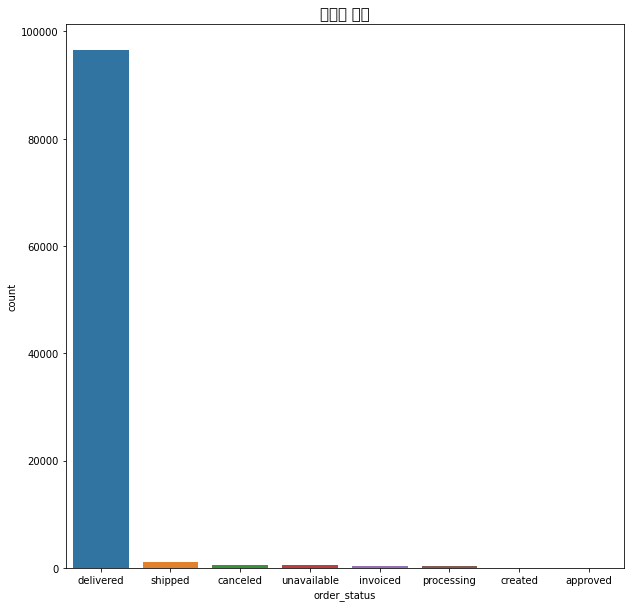

In [45]:
## single_countplot 대체

plt.figure(figsize=(10,10))
plt.title('주문별 상태', fontsize=15)
sns.countplot(df_orders['order_status'], order=df_orders['order_status'].value_counts().index)

전체 상태중 'delivered'가 가장 많았으며 나머지 상태는 3%에 불과

다음 플롯에서는 구매 주문에 관한 전자 상거래의 증가 추세에 대해 살펴보겠습니다.  
이를 위해 다음 항목에서 **order_purchase_timestamp**에 대한 정보를 추출해야 합니다. 
1. 타임스탬프 컬럼 변환
2. 시간 속성 추출(연/월/일/요일 및 시간)
3. 해당 속성을 통한 전자상거래 추세 파악

In [46]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


NameError: name 'format_spines' is not defined

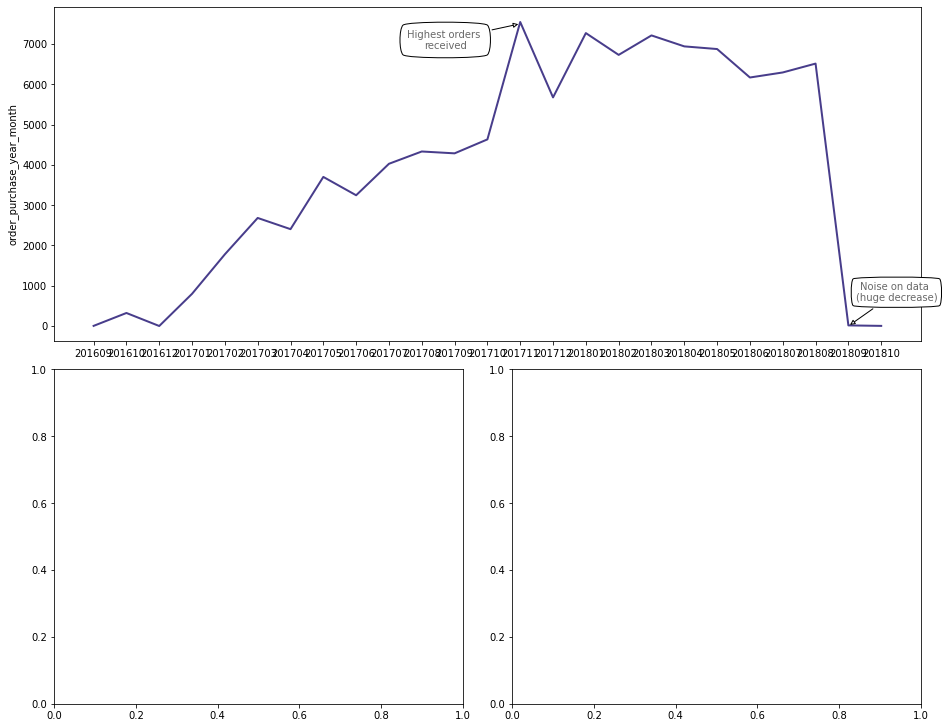

In [49]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

## E-Commerce Around Brazil

## E-Commerce Impact on Economy 

## Payment Type

# Natural Language Processing
자연어 처리

## Data Understanding

## RegEx

### Breake Line and Carriage Return
breake Line - 개행문자? 

### Site and Hiperlinks

### Dates

### Money

### Numbers

### Negation

### Special Characters

### Additional Whitespaces

## StopWords

## Stemming

## Feature Extraction

### CountVectorizer

### TF-IIDF